# Calibration 

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import transitions

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Single = RetirementClass()

### Survival probabilities

In [7]:
def survival(model,age,ma,hs,scale_m=0.0,scale_f=0.0):
    par = model.par
    if ma == 1:
        rsm = par.reg_survival_male
        dx = np.minimum(1,np.exp(rsm[0] + rsm[1]*age))
        sx = (1 - dx)*((hs==0)*(1-scale_m) + (hs==1)*(1+scale_m))
    elif ma == 0:
        rsf = par.reg_survival_female
        dx = np.minimum(1,np.exp(rsf[0] + rsf[1]*age))
        sx = (1 - dx)*((hs==0)*(1-scale_f) + (hs==1)*(1+scale_f))        
    return np.minimum(1,sx)

def middellevetid(model,age,ma,hs,scale_m=0.0,scale_f=0.0):
    sx = survival(model,age,ma,hs,scale_m,scale_f)
    lx = np.zeros(len(ages))
    lx[0] = 100000
    Lx = np.zeros(len(ages))
        
    for ag in range(len(ages)):
        if ag > 0:
            lx[ag] = lx[ag-1]*sx[ag-1]
            Lx[ag-1] = np.mean((lx[ag-1],lx[ag]))
            
    Tx = np.sum(Lx,axis=0)
    return Tx/lx[0]

In [29]:
ages = np.arange(57,111)
x = np.linspace(0.1,0.5,100)
diff = np.zeros((2,len(x)))
for i in range(len(x)):
    diff[0,i] = middellevetid(Single,ages,0,1,scale_f=x[i]/100) - middellevetid(Single,ages,0,0,scale_f=x[i]/100)
    diff[1,i] = middellevetid(Single,ages,1,1,scale_m=x[i]/100) - middellevetid(Single,ages,1,0,scale_m=x[i]/100)    

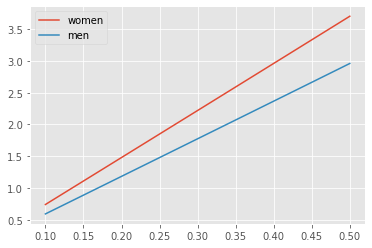

In [30]:
plt.plot(x,diff[0], label='women')
plt.plot(x,diff[1], label='men')
plt.legend()

In [49]:
scale_m = 0.422/100
scale_f = 0.216/100
women_ls = round(middellevetid(Single,ages,0,0,scale_f=scale_f),2)
women_base = round(middellevetid(Single,ages,0,0),2)
women_hs = round(middellevetid(Single,ages,0,1,scale_f=scale_f),2)
men_ls = round(middellevetid(Single,ages,1,0,scale_m=scale_m),2)
men_base = round(middellevetid(Single,ages,1,0),2)
men_hs = round(middellevetid(Single,ages,1,1,scale_m=scale_m),2)

In [50]:
data = [(women_hs, men_hs), (women_base, men_base), (women_ls, men_ls), (women_hs-women_ls-57, (men_hs-men_ls-57))]

In [51]:
pd.DataFrame(data, columns=['Women', 'Men'], index=['High skilled', 'Baseline', 'Low skilled', 'High skilled - Low skilled'])+57

,Women,Men
High skilled,83.20,80.66
Baseline,82.38,79.36
Low skilled,81.60,78.16
High skilled - Low skilled,1.60,2.50
